## Load Data
The data set is UNBC-McMaster Shoulder Pain Data

In [ ]:
%pip install face-alignment

In [ ]:
import cv2 as cv
import math
from face_alignment import FaceAlignment
from face_alignment import LandmarksType
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
from PIL import Image
import os
import torch
from torchvision.transforms import functional as TF
import torchvision.transforms as transforms

In [ ]:
# Access the google drive
from google.colab import drive
drive.mount('/content/drive')
path_image = "/content/drive/MyDrive/Colab Notebooks/Dataset/Images"

if os.path.exists(path_image):
    print("Path is found.",sep=' ', end=' ', flush=True)
    if os.scandir(path_image):
        print("Folder is not empty.")


Mounted at /content/drive


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Define the directory where your data is stored
data_directory = '/content/drive/MyDrive/Colab Notebooks/Dataset'
img_dir = data_directory + '/Images'

images = os.listdir(img_dir)


The total count of the VAS from 0 - 10


In [ ]:
VAS_label_dir = data_directory + '/Sequence_Labels/VAS'

label_count = {}

for subject in os.listdir(VAS_label_dir):
    for label in os.listdir(VAS_label_dir + '/' + subject):
        with open(os.path.join(VAS_label_dir+ '/' + subject, label), 'r') as vas_label_file:
            vas = int(float(vas_label_file.read().strip()))
            if label_count.get(vas) is None:
                label_count[vas] = 1
            else:
                temp = label_count.get(vas)
                #update count value
                label_count[vas] += 1

print(label_count)


{3: 20, 4: 21, 2: 24, 0: 35, 7: 6, 1: 42, 8: 18, 6: 11, 5: 11, 10: 2, 9: 10}


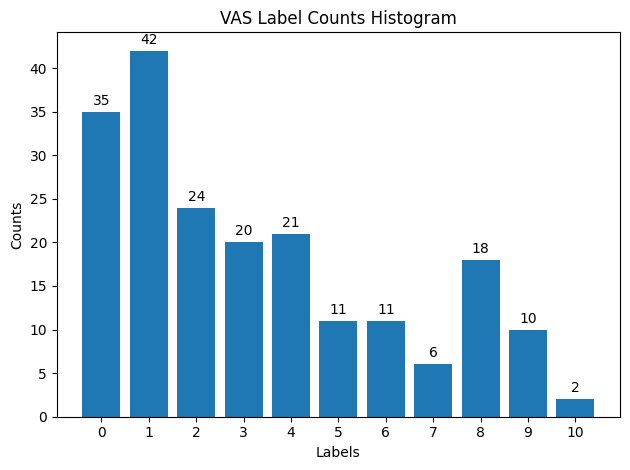

In [ ]:
# Extract labels and counts from the dictionary
sorted_label_counts = dict(sorted(label_count.items()))

labels = list(sorted_label_counts.keys())
counts = list(sorted_label_counts.values())

# Create a bar plot (histogram)
plt.bar(labels, counts,tick_label=labels)

# Adding labels and title
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.title('VAS Label Counts Histogram')

# Display the plot
plt.tight_layout()

for x, y in zip(labels, counts):
    plt.annotate(f'{y}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

plt.show()





Frames vs PSPI Score

In [ ]:
from matplotlib.layout_engine import ConstrainedLayoutEngine
def print_img_PSPI(img_dir, subject, sequence):
    image_filenames = []
    pain_intensity_labels = []
    average_intensity_scores = []
    image_filenames_by_batch = []

    sequence_dir = os.path.join(img_dir, subject , sequence)
    image_label_dir = os.path.join(data_directory, "Frame_Labels","PSPI", subject, sequence)

    for filename in sorted(os.listdir(sequence_dir)):
        if filename.endswith('.png'):
            # Load the image
            img = cv2.imread(os.path.join(sequence_dir, filename))
            image_filenames.append(img)

            # Load the pain intensity label from the corresponding text file
            label_filename = os.path.splitext(filename)[0] + '_facs.txt'

            with open(os.path.join(image_label_dir, label_filename), 'r') as label_file:
                pain_intensity = int(float(label_file.read().strip()))
                pain_intensity_labels.append(pain_intensity)


   # Calculate average intensity scores for each batch (for demonstration purposes)
    num_batches = 10
    batch_size = len(image_filenames) // num_batches

    for batch_index in range(num_batches):
        start_index = batch_index * batch_size
        end_index = start_index + batch_size


        # Calculate the average intensity score for the current batch
        average_intensity = np.mean(pain_intensity_labels[start_index:end_index])
        average_intensity_scores.append(pain_intensity_labels[start_index])

    # Create a smooth curve fitted graph
    x = np.arange(0, num_batches)
    y = average_intensity_scores

    # Use make_interp_spline for a smooth curve fit
    x_smooth = np.linspace(x.min(), x.max(), 300)
    y_smooth = make_interp_spline(x, y, k=3)(x_smooth)

    fig = plt.figure(figsize=(16, 10),constrained_layout= True)

    gs1 = fig.add_gridspec(2, num_batches,height_ratios=[1,3])

    # Create subplots for the images in the first row
    for i in range(num_batches):
        ax = fig.add_subplot(gs1[0, i])
        ax.imshow(cv2.cvtColor(image_filenames[i * batch_size], cv2.COLOR_BGR2RGB))
        ax.axis('off')

    # Plot the smooth curve in the second row
    ax = fig.add_subplot(gs1[1, :num_batches])
    ax.plot(x_smooth, y_smooth, label='Smooth Curve', linewidth=2)
    ax.scatter(x, y, color='red', marker='o', label='Data Points')
    ax.set_xlabel('Batch Index')
    ax.set_ylabel('Average Pain Intensity')
    ax.set_title('Smooth Curve Fitted Graph - ' + sequence)
    ax.legend()
    ax.grid(True)

    plt.show()



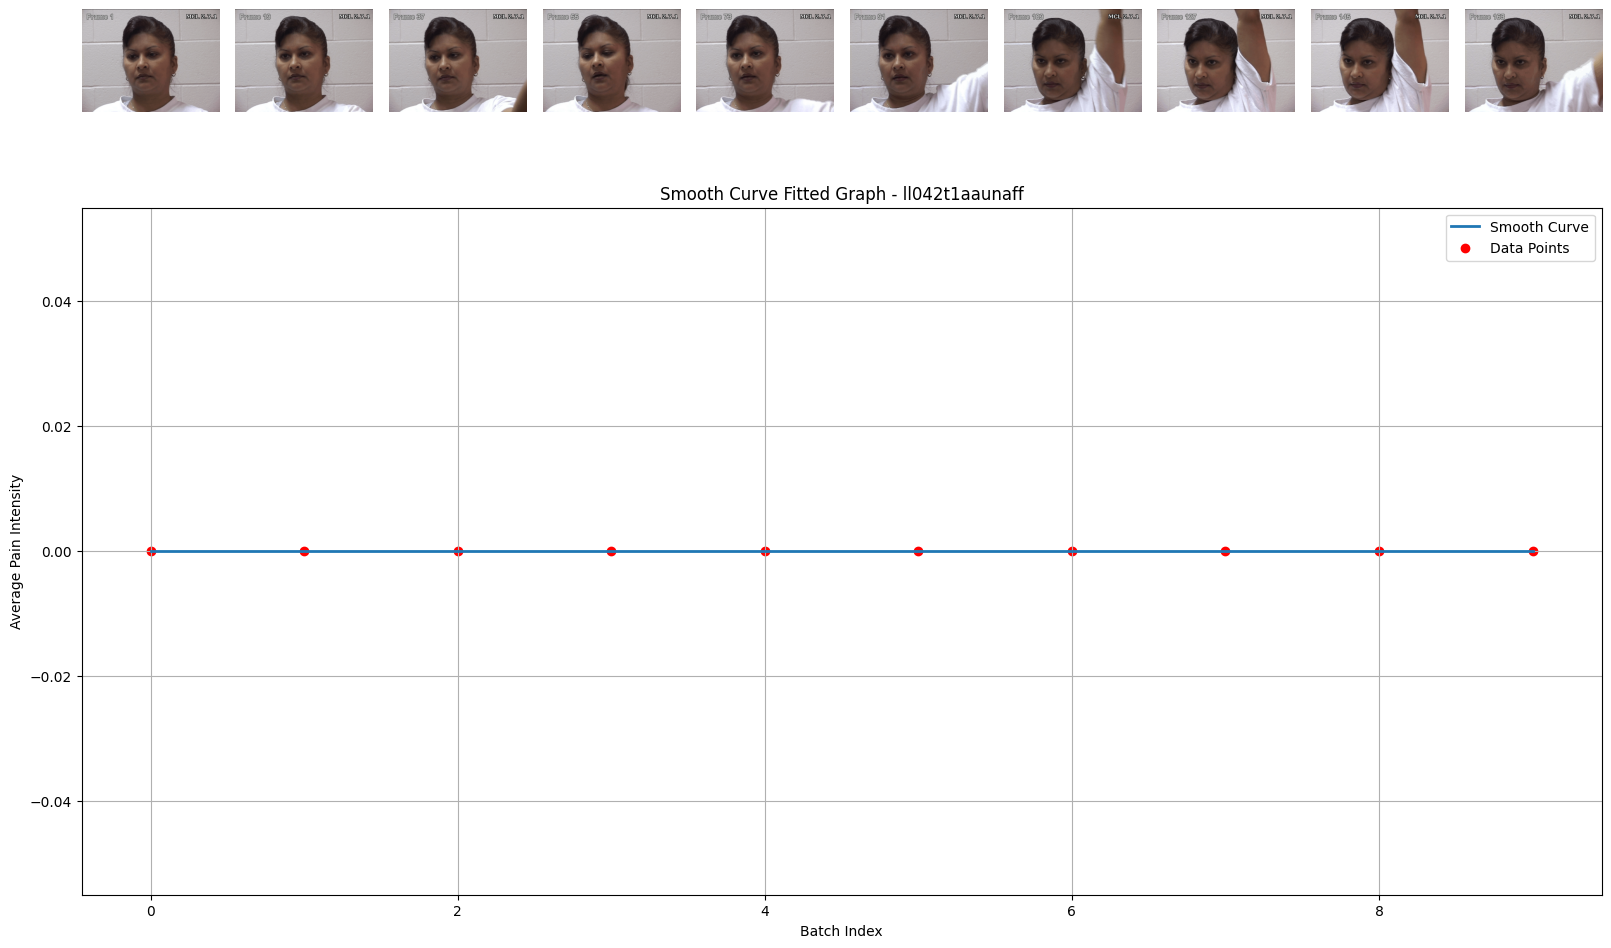

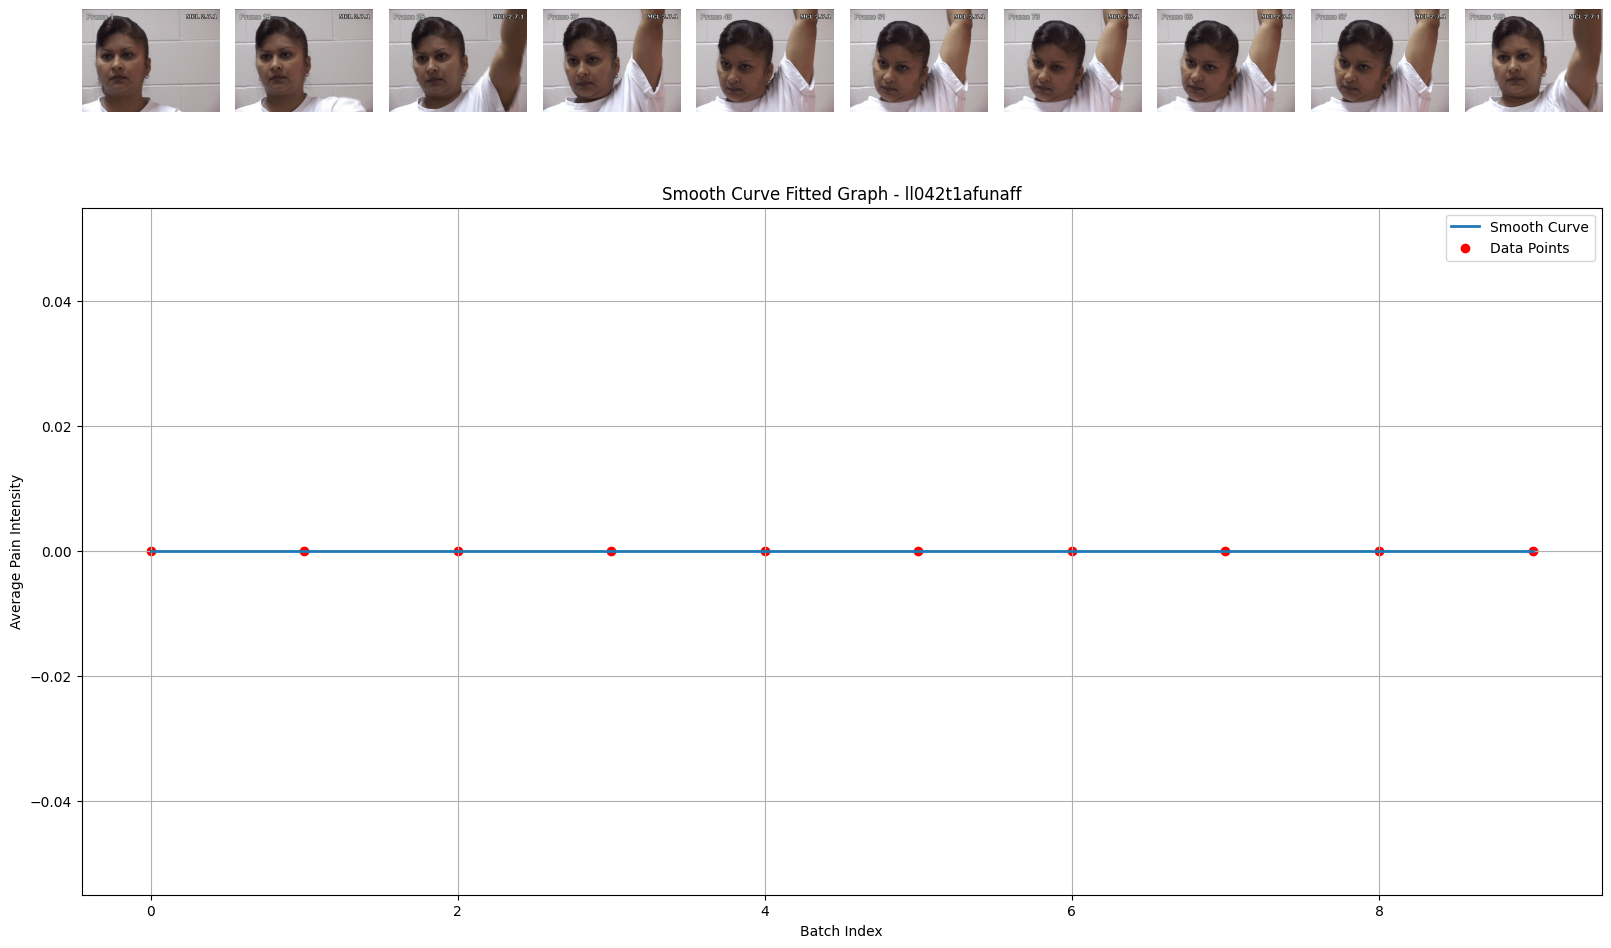

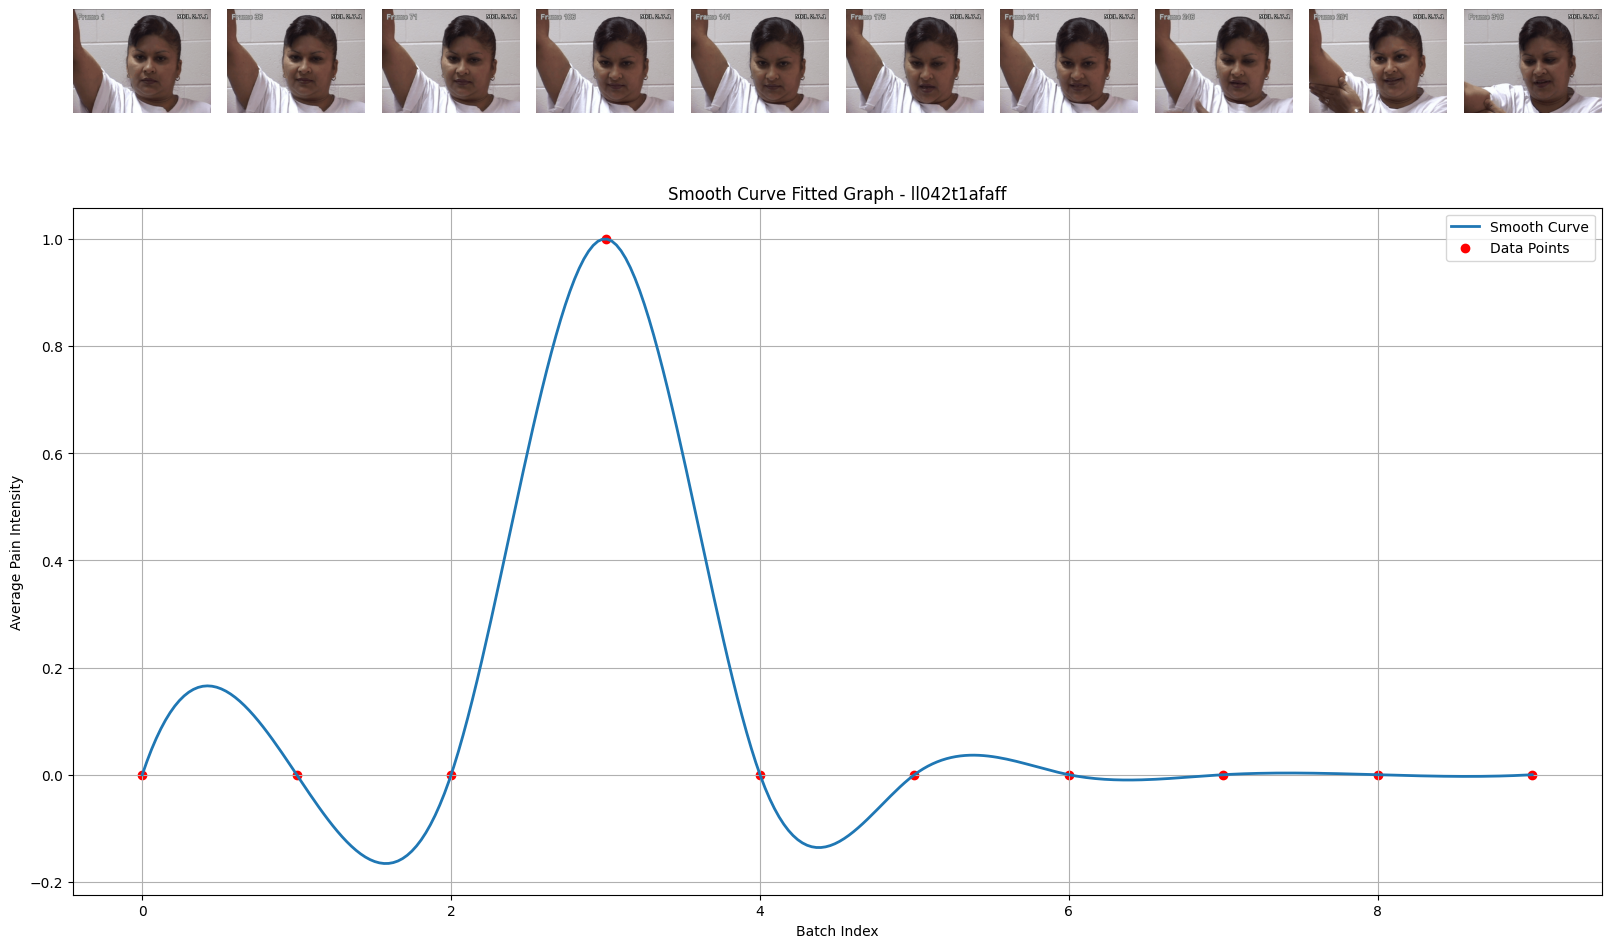

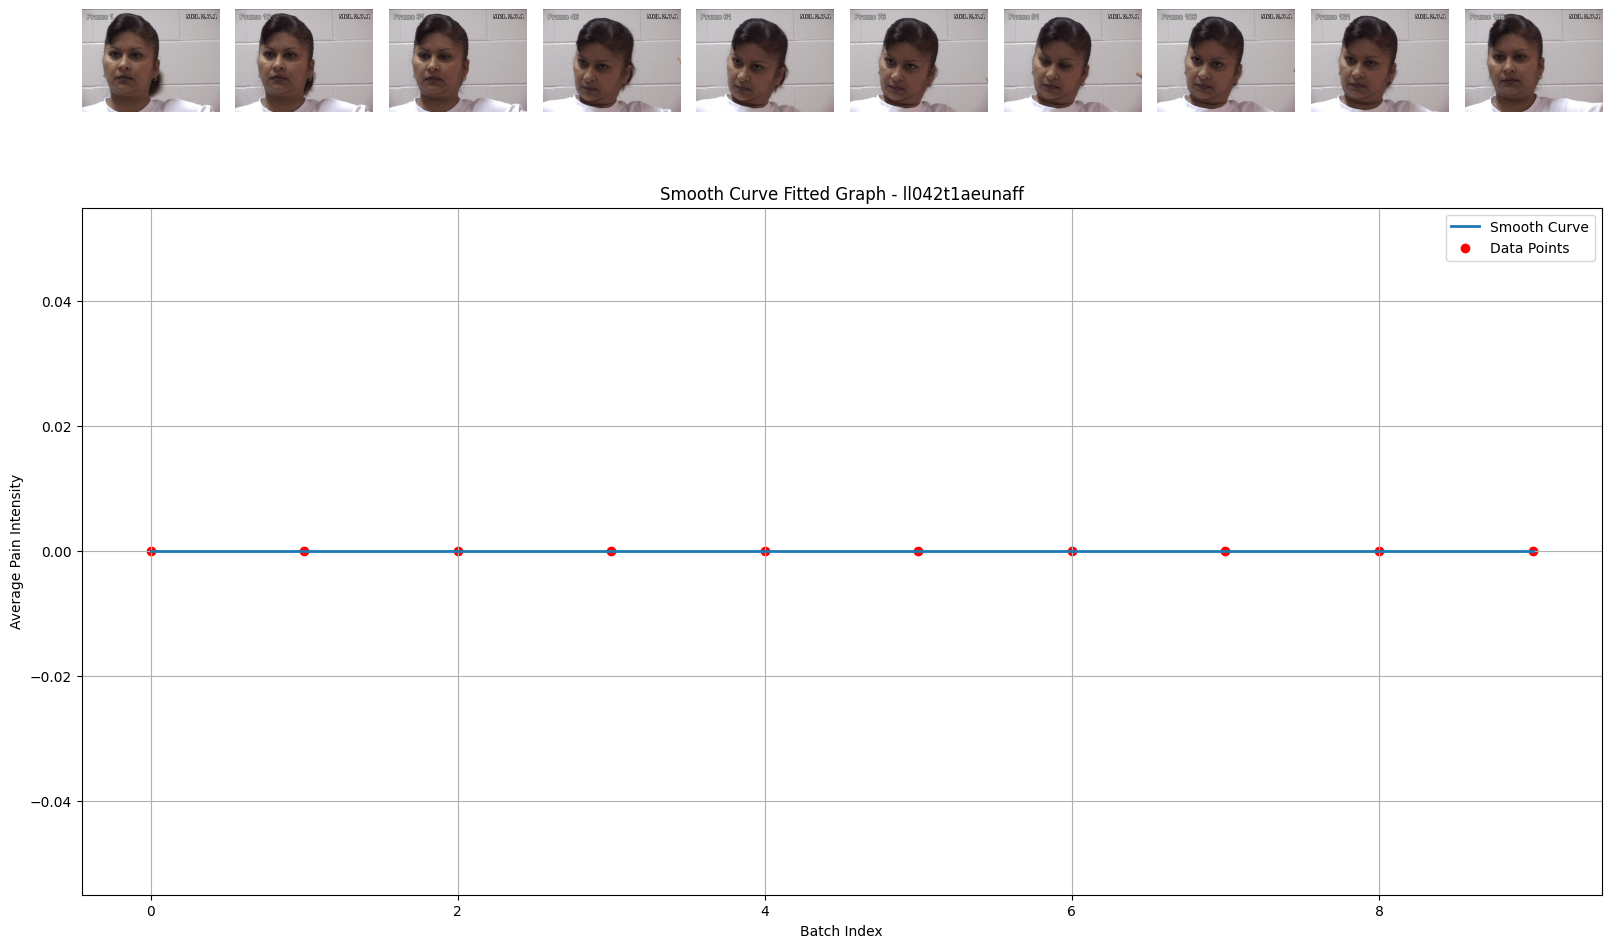

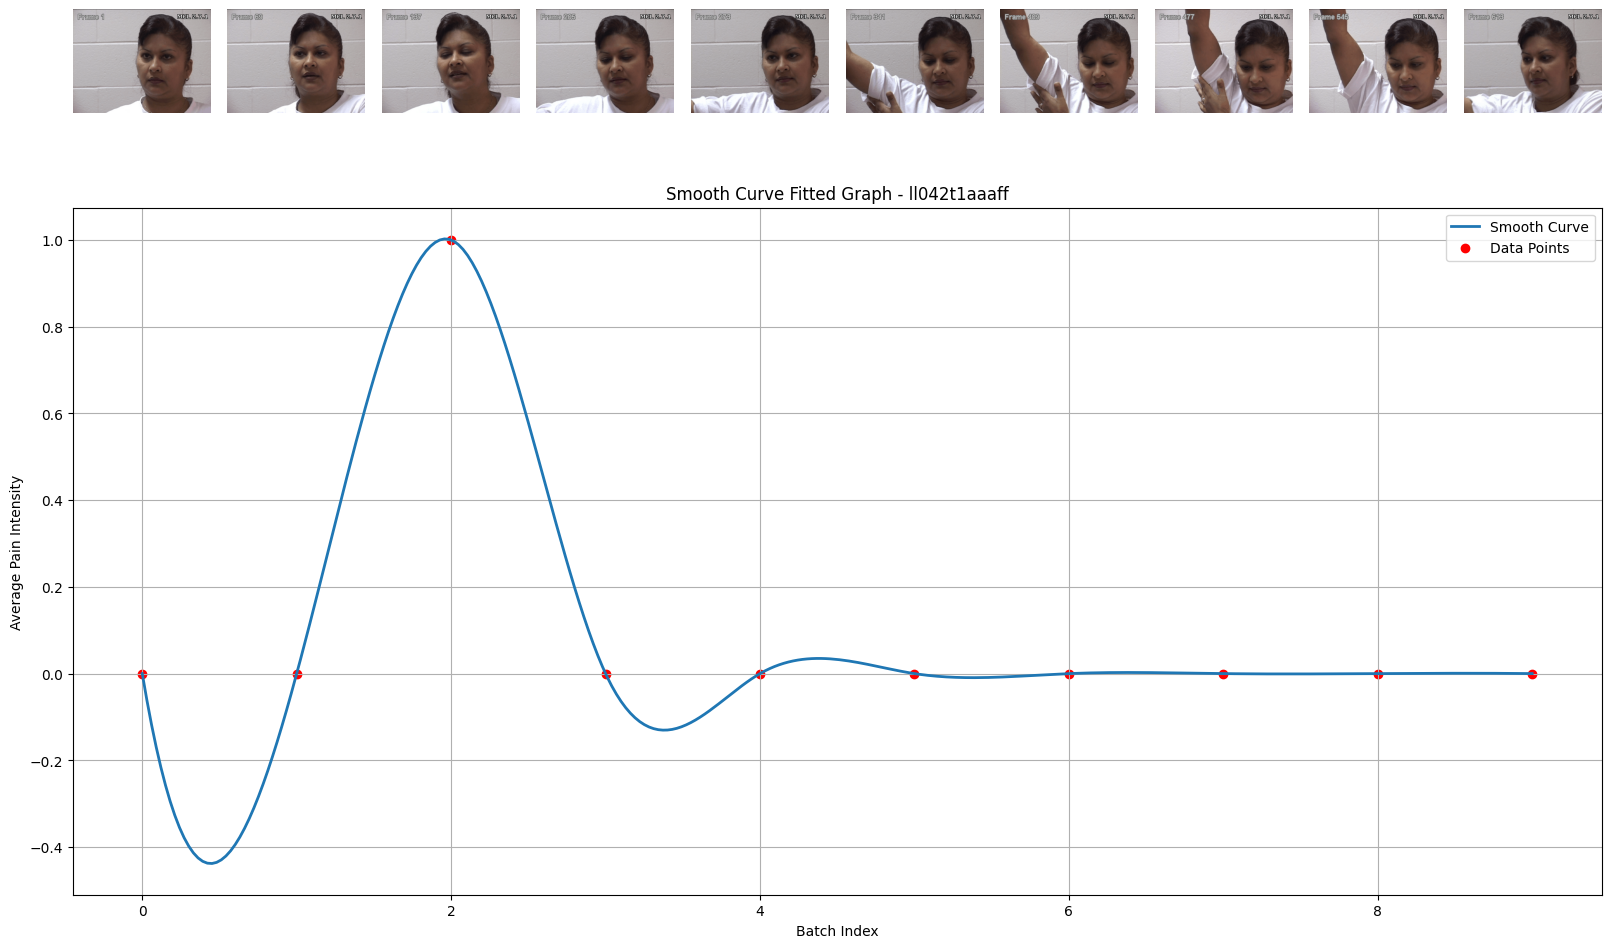

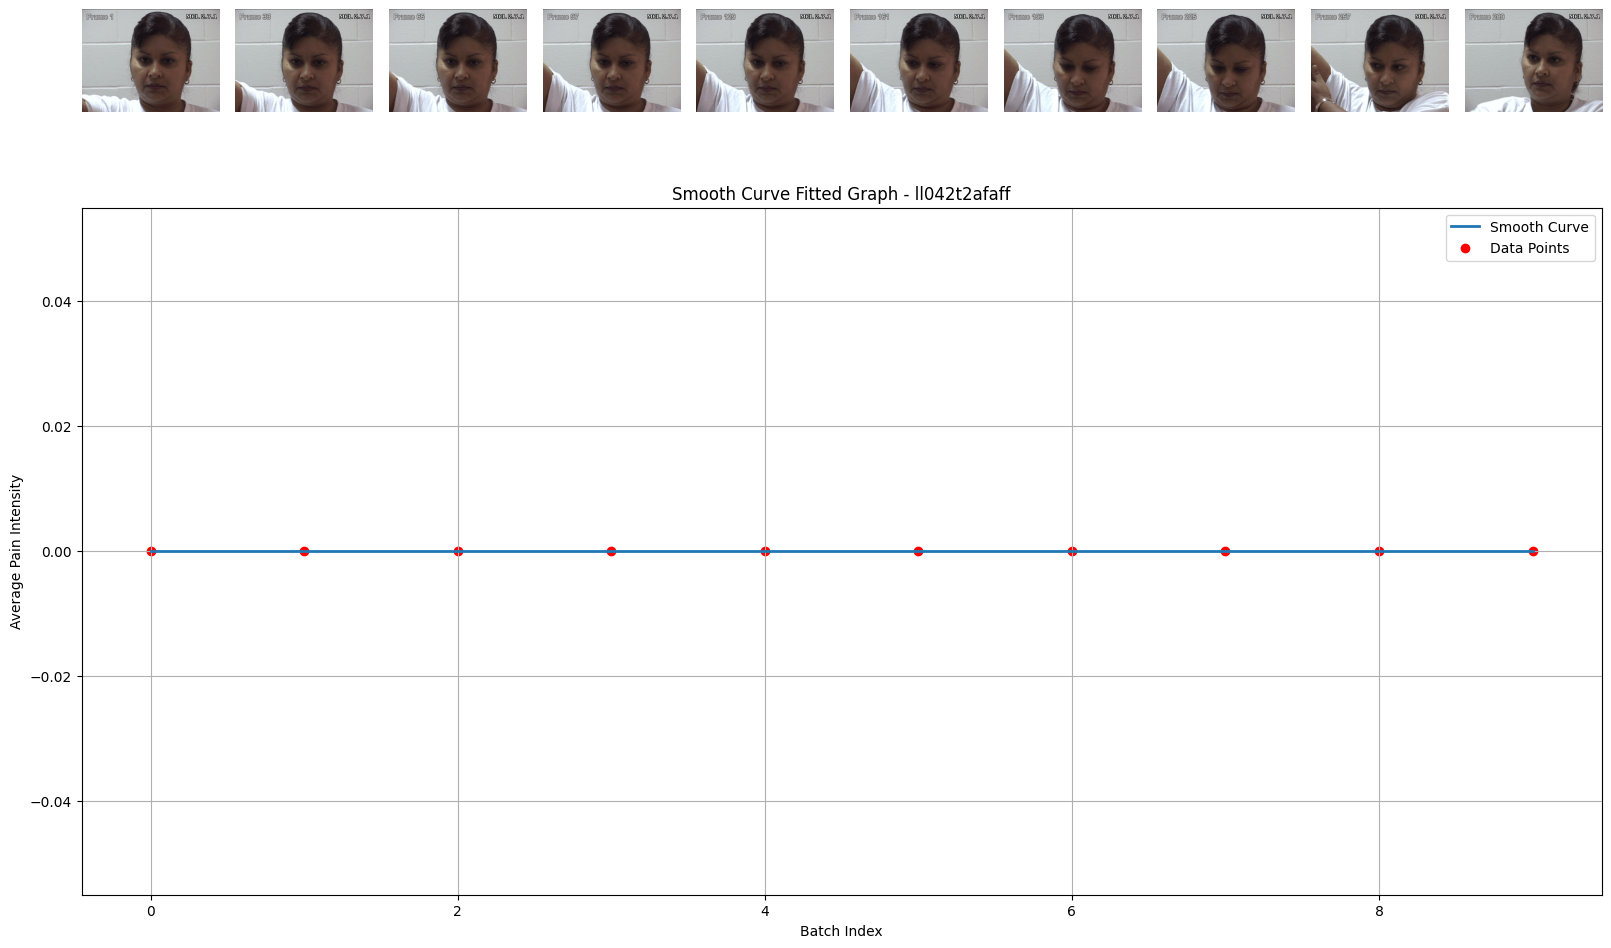

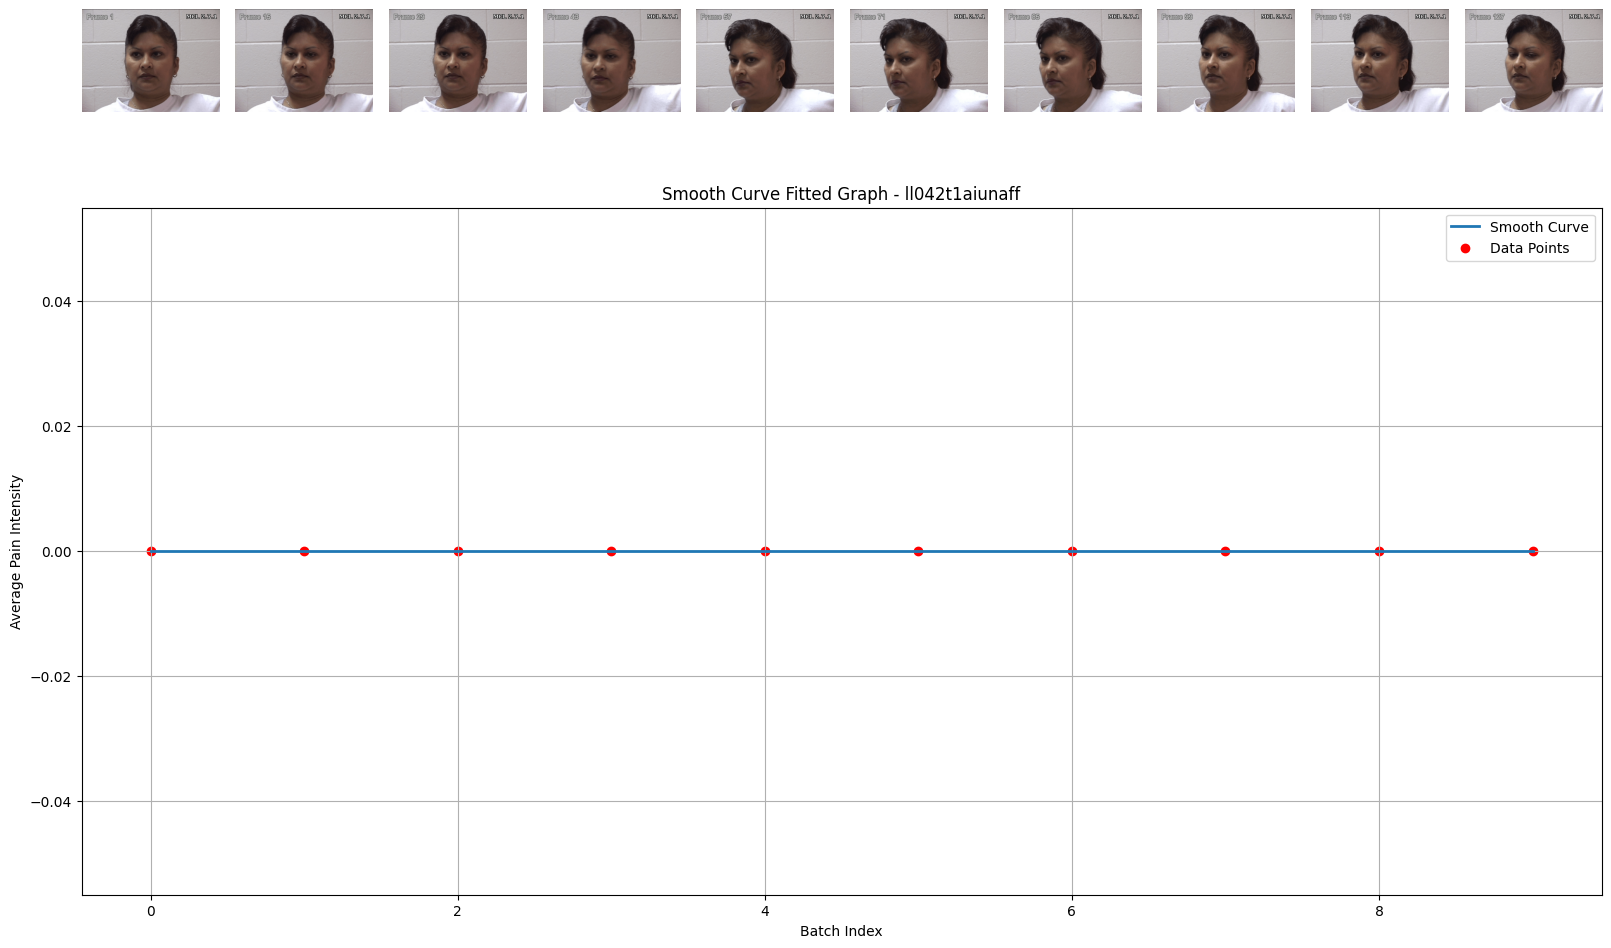

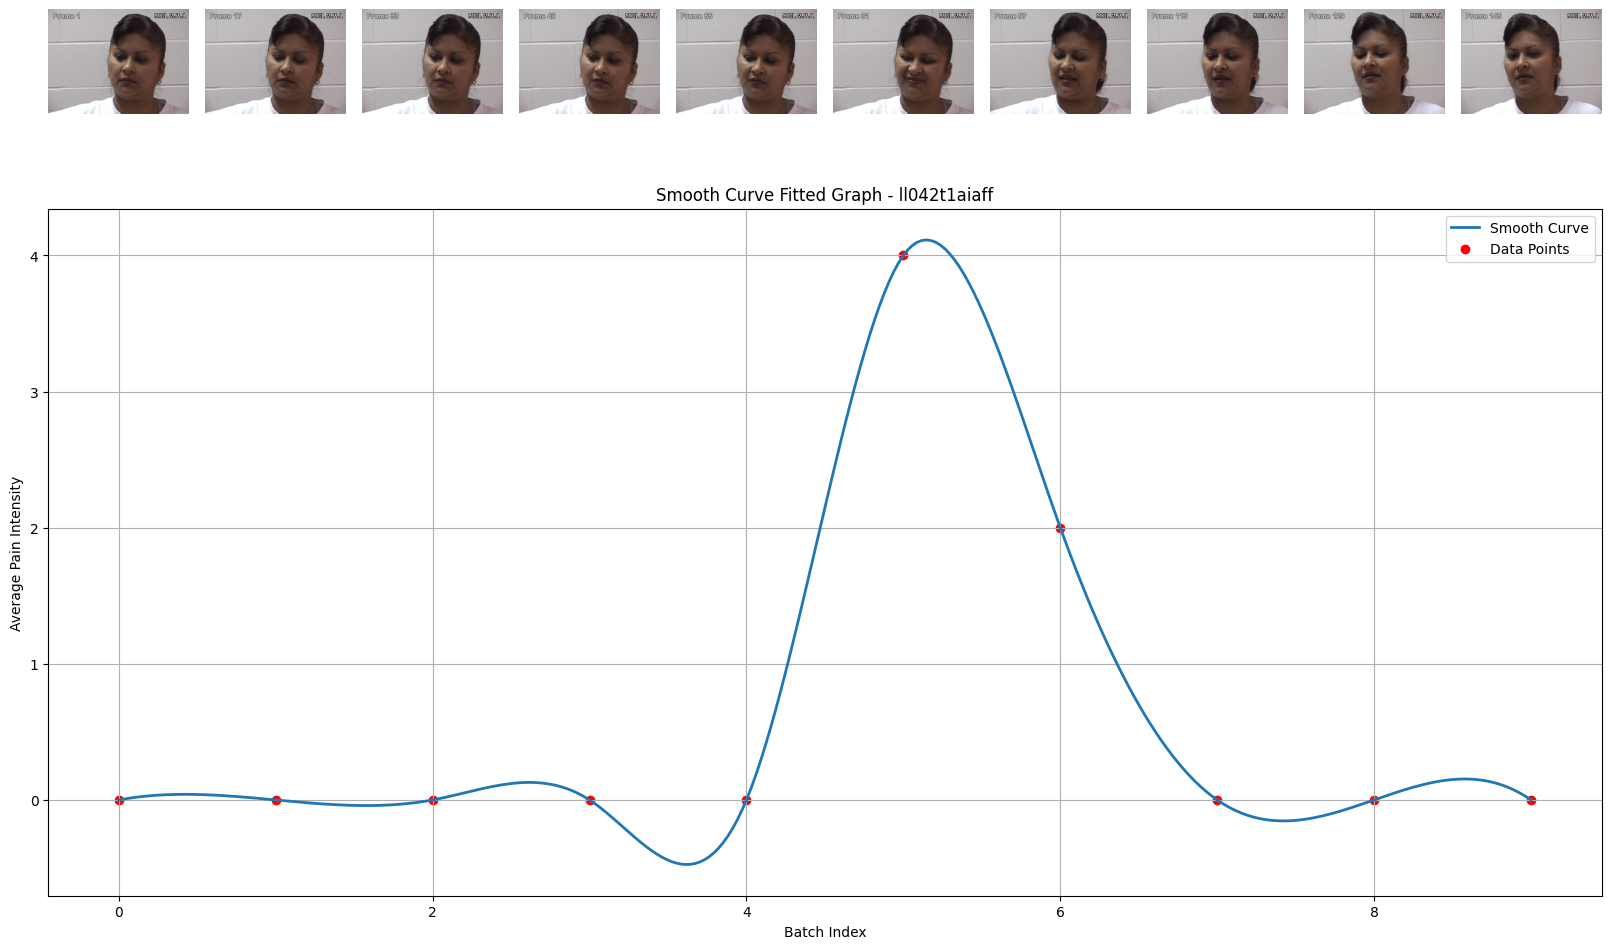

In [ ]:
# Initialize lists to store image filenames and pain intensity labels
for subject in images:
    for sequence in os.listdir(img_dir+'/'+subject):
        print_img_PSPI(img_dir, subject, sequence)

    break


## Preprocess the data
- enhance the appearance of the face
- align the face
- crop the face

In [ ]:
from tqdm import tnrange
from time import sleep

class preprocess():

    def __init__(self, frames, subject_code, sequence_code):
        super(preprocess, self).__init__()
        self.frames = frames
        self.subject_code = subject_code
        self.sequence_code = sequence_code
        # Do landmark detection on the input frames for face recognition proposes
        self.landmarkDetection()

        # Mask the non-face area with black pixels
        self.frames = self.maskFace()

        # Tilt and align the face at centre, then crop the frames according to the face region
        self.frames = self.tiltAlign()

        # self.savePreprocessedimages()

        self.tensor = self.padding_normalization(24)

    def savePreprocessedimages(self):
        path = "/content/Preprocessed"
        target_dir =""
        # check filepath exist
        if not os.path.exists(path):
            print("checking root...")
            os.mkdir(path)
        subject_path = os.path.join(path, self.subject_code)

        if not os.path.exists(subject_path):
            print("checking subject folder")
            os.mkdir(subject_path)
        sequence_path = os.path.join(subject_path, self.sequence_code)

        if not os.path.exists(sequence_path):
            print("checking sequence path")
            os.mkdir(sequence_path)
        target_dir = sequence_path


        # if len(os.listdir(target_dir)) != 0:
        #     self.delete_files_in_directory(path)

        print(target_dir)
        for i in range (len(self.frames)):
            n = f'{i+1:03}'
            cv.imwrite(f'{target_dir}\\{self.sequence_code}{n}.png', cv.cvtColor(self.frames[i], cv.COLOR_BGR2RGB))

    def delete_files_in_directory(self, directory_path):
        try:
            with os.scandir(directory_path) as entries:
                for entry in entries:
                    if entry.is_file():
                        os.unlink(entry.path)
                print("All files deleted successfully.")
        except OSError:
            print("Error occurred while deleting files.")

    def landmarkDetection(self):
        frames = self.frames
        output = []
        framesLandmark = []
        model = FaceAlignment(landmarks_type=LandmarksType.TWO_D, face_detector='blazeface',
                              face_detector_kwargs={'back_model': True}, device='cuda')
        for n in tnrange(len(frames),desc="Landmark Detection_"+self.sequence_code):
            img = (frames[n])
            img = img.copy()
            landmarks = model.get_landmarks(img)
            landmarks_tuple = []
            if landmarks is not None:
                # Iterate over the detected faces
                for pred in landmarks:
                    # Draw landmarks on the frame
                    for point in pred:
                        x, y = point
                        landmarks_tuple.append((int(x), int(y)))
                        if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                            cv.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)

            framesLandmark.append(landmarks_tuple)
            output.append(img)
            sleep(0.01)
        self.framesLandmark = framesLandmark

    def tiltAlign(self):
        frames = self.frames
        output =[]
        for i in range(len(frames)):
            img = frames[i]
            landmarkTuple = self.framesLandmark[i]
            # Landmark index of reight eye and left eye are
            right_eye_cood = [(landmarkTuple[39][0] + landmarkTuple[36][0])/2, (landmarkTuple[39][1] + landmarkTuple[36][1])/2]
            left_eye_cood = [(landmarkTuple[45][0] + landmarkTuple[42][0])/2, (landmarkTuple[45][1] + landmarkTuple[42][1])/2]
            x1, y1 = right_eye_cood
            x2, y2 = left_eye_cood

            a = abs(y1 - y2)
            b = abs(x2 - x1)
            c = math.sqrt(a * a + b * b)

            cos_alpha = (b * b + c * c - a * a) / (2 * b * c)

            alpha = np.arccos(cos_alpha)
            alpha = (alpha * 180) / math.pi
            img = Image.fromarray(img)
            if y1>y2 :
                alpha = -alpha
            img = np.array(img.rotate(alpha))
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            output.append(img)
        return output

    def maskFace(self):
        routes = [i for i in range (16,-1,-1)] + [i for i in range (17,26+1)]

        frames = self.frames
        output = []
        for n in range(len(frames)):
            routes_cod = []
            mask = None
            out = None
            landmarks_tuple = self.framesLandmark[n]
            img = (frames[n])
            img = img.copy()
            img2 = img.copy()
            for i in range (0, len(routes)-1):
                source_point = routes[i]
                target_point = routes[i+1]

                source_cod = landmarks_tuple[source_point]
                target_cod = landmarks_tuple[target_point]
                routes_cod.append(source_cod)
                cv.line(img, (source_cod), (target_cod),(255,255,255),2)

            routes_cod = routes_cod+[routes_cod[0]]

            mask = np.zeros((img.shape[0], img.shape[1]))
            mask = cv.fillConvexPoly(mask, np.array(routes_cod),1)
            mask = mask.astype(np.bool_)
            out = np.zeros_like(img)
            out[mask] = img2[mask]
            # plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB))
            output.append(cv.cvtColor(self.cropFaceArea(out, mask), cv.COLOR_BGR2RGB))
        return output

    def cropFaceArea(self, frame, mask):

        gray = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
        contours, _ = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        # Get the bounding box of the largest contour

        largest_contour = max(contours, key=cv.contourArea)
        x, y, w, h = cv.boundingRect(largest_contour)

        # Crop the image to the size of the masked face
        cropped_image = frame[y:y+h, x:x+w]

        return cropped_image

    def padding_normalization(self, target_length):
        """
        Preprocesses a sequence of images and pads them to a target length.

        Args:
            images (list): List of PIL images.
            target_length (int): Desired length of the sequence after padding.

        Returns:
            torch.Tensor: Tensor of preprocessed and padded images.
        """
        # Resize the images to a consistent size
        array_images = self.frames
        images =[]

        for image in array_images:
            images.append((Image.fromarray(image)))

        resized_images = [TF.resize((img), [224, 224]) for img in images]

        # Convert the images to tensors
        tensor_images = [TF.to_tensor(img) for img in resized_images]

        # Stack the tensor images along a new dimension (sequence dimension)
        tensor_sequence = torch.stack(tensor_images)

        # Calculate the current length of the sequence
        current_length = tensor_sequence.size(0)

        # Pad the sequence if necessary
        if current_length < target_length:
            padding_length = target_length - current_length
            padding = torch.zeros(padding_length, *tensor_sequence.shape[1:])
            tensor_sequence = torch.cat((tensor_sequence, padding))

        # Normalize the tensor sequence
        # Define the mean and standard deviation values for normalization
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        # Apply normalization to the tensor sequence
        normalize = transforms.Normalize(mean=mean, std=std)
        normalized_sequence = normalize(tensor_sequence)

        return normalized_sequence



In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Load the images into a array
# The structure of the dataset folder
# root > Images > Subject > Sequences > *frame

root_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset"
images_data_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Images" # Path that contains all the subject frames of sequences
labels_dir = os.path.join(root_dir, 'Sequence_Labels', "VAS")

# Create lists to store preprocessed images and labels
preprocessed_images = []
preprocessed_labels = []

# Iterate through subject folders (assuming subject folders are labeled with integers)
for subject_folder in os.listdir(images_data_dir):

    subject_path = os.path.join(images_data_dir, subject_folder)

    # Skip non-directory files
    if not os.path.isdir(subject_path):
        continue

    # Iterate through sequence folders
    for sequence_folder in os.listdir(subject_path):
        sequence_path = os.path.join(subject_path, sequence_folder)

        # Initialize a list to store image frames in the current sequence
        sequence_images = []

        # Skip non-directory files
        if not os.path.isdir(sequence_path):
            continue

        # Iterate through frames in the sequence
        for frame_filename in os.listdir(sequence_path):
            frame_path = os.path.join(sequence_path, frame_filename)

            # Load the image
            img = cv2.imread(frame_path)

            # Append the image to the images list
            sequence_images.append(img)

        preprocessing = preprocess(sequence_images, subject_folder, sequence_folder)

        # Stack the image frames to create a sequence tensor
        sequence_tensor = np.stack(preprocessing.tensor)

        # Append the sequence tensor to the list of preprocessed images
        preprocessed_images.append(sequence_tensor)

        # Read the label for the current sequence from the Labels directory
        label_file_path = os.path.join(labels_dir, subject_folder, sequence_folder + '.txt')
        with open(label_file_path, 'r') as label_file:
            sequence_label = int(float(label_file.read().strip()))

        # Append the label to the list of preprocessed labels
        preprocessed_labels.append(sequence_label)

# Convert the lists of preprocessed images and labels to NumPy arrays
preprocessed_images = np.array(preprocessed_images)
preprocessed_labels = np.array(preprocessed_labels)
